# EBPF malware detection with machine learning

This scientific research project involves detecting malware via EBPF using machine learning algorithms.

In this part, we retrieve process datasets, and based on the various features, we must classify whether the process is malware or not.

Among the features we have system calls such as create, delete, open, the maximum number of creates in 1 second and the total number of creates in the process, and others...
![RandomTree_Full.PNG](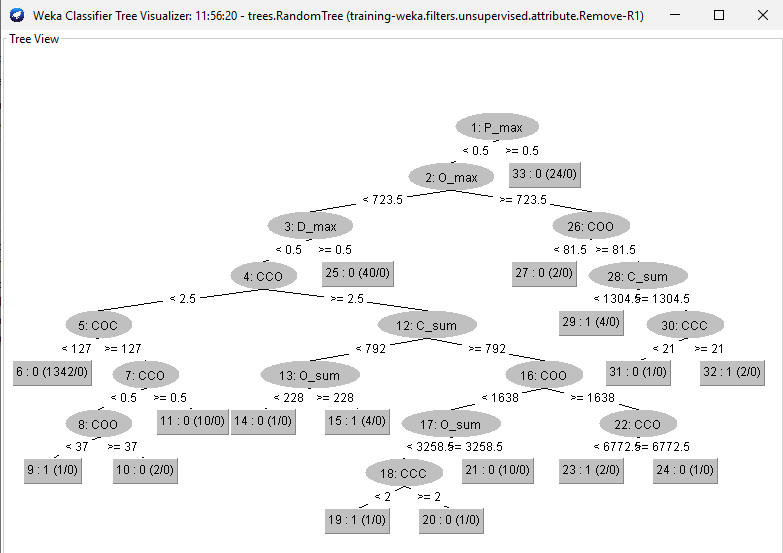![RandomTree_Full.PNG](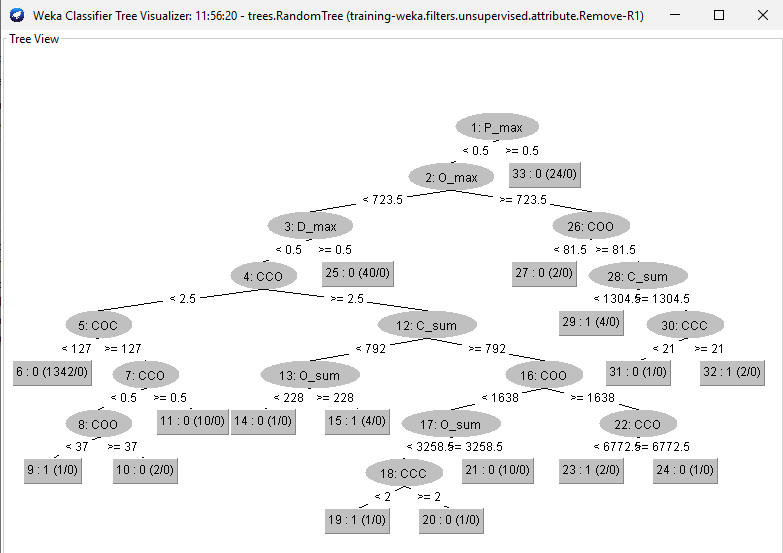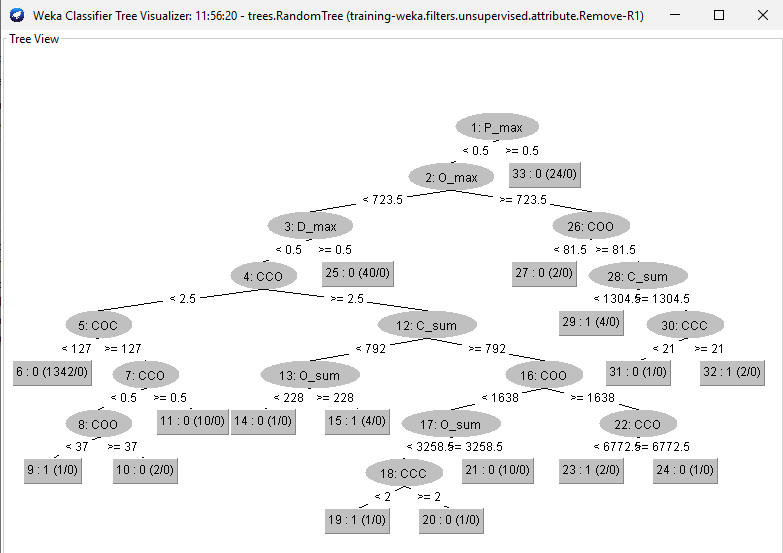))


**Authors**
- Sabir Mohamed Ben Ali
- Anthony Becuwe
- Agustin Bouchon
- Remi Tang

**Summary**  

Introduction  
I / Preprocessing data  
II / Select attribute  
III / Solve the unbalanced data problem  
Conclusion

## Introduction


### Sources
- Thomas Philippart : https://github.com/TomasPhilippart/ebpfangel
- Date: 5 April 2024

This is a dataset presenting ransomware detection systeme that combine eBPF and Machine Learning.
There are many features which correspond for the most of all to system call.
There is one label which indicate if the patterns used in feature is the behaviour of a malware or not.

### Weka
For this research, we used Weka for attribute relevance, learning model optimization, data analysis and tree generation.

## I / Preprocessing data

### 1. Retrieving data from the github repository
https://github.com/TomasPhilippart/ebpfangel/tree/main/data

Import the necessary libraries

In [ ]:
!pip install arff

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import arff

from matplotlib import pyplot as plt

Import the dataset testing and training with pandas

In [ ]:
testing_data = pd.read_csv("testing_data.csv")
testing_labels = pd.read_csv("testing_labels.csv")
training_data = pd.read_csv("training_data.csv")
training_labels = pd.read_csv("training_labels.csv")

In [ ]:
testing_data.head()

,PID,C_max,C_sum,D_max,D_sum,E_max,E_sum,O_max,O_sum,P_max,...,OCC,OCD,OCO,ODC,ODD,ODO,OEE,OOC,OOD,OOO
0,1.0,126,263,82,573,0,0,21489,76714,0,...,0,0,262,0,138,49,0,258,60,75945
1,961.0,0,0,0,0,0,0,672,2115,0,...,0,0,0,0,0,0,0,0,0,2113
2,962.0,0,0,0,0,0,0,25,57,0,...,0,0,0,0,0,0,0,0,0,55
3,993.0,5,27,2,8,0,0,38,161,1,...,8,1,0,1,1,0,0,9,1,140
4,1312.0,0,0,0,0,0,0,3,18,0,...,0,0,0,0,0,0,0,0,0,16


In [ ]:
testing_labels.head()

,PID
0,13763
1,23248
2,23249
3,23250
4,23251


### 2. Merge features and label dataset

The label dataset lists all PIDs containing malware, so I have to do a pre-processing this dataset, and merge it with the features dataset

In [ ]:
testing_class = [1 if x in testing_labels["PID"].to_numpy() else 0 for x in testing_data["PID"].to_numpy()]
testing_class = pd.DataFrame({'Labels': testing_class})
testing = pd.concat([testing_data, testing_class], axis=1)
testing.head()

,PID,C_max,C_sum,D_max,D_sum,E_max,E_sum,O_max,O_sum,P_max,...,OCD,OCO,ODC,ODD,ODO,OEE,OOC,OOD,OOO,Labels
0,1.0,126,263,82,573,0,0,21489,76714,0,...,0,262,0,138,49,0,258,60,75945,0
1,961.0,0,0,0,0,0,0,672,2115,0,...,0,0,0,0,0,0,0,0,2113,0
2,962.0,0,0,0,0,0,0,25,57,0,...,0,0,0,0,0,0,0,0,55,0
3,993.0,5,27,2,8,0,0,38,161,1,...,1,0,1,1,0,0,9,1,140,0
4,1312.0,0,0,0,0,0,0,3,18,0,...,0,0,0,0,0,0,0,0,16,0


In [ ]:
training_class = [1 if x in training_labels["PID"].to_numpy() else 0 for x in training_data["PID"].to_numpy()]
training_class = pd.DataFrame({'Labels': training_class})
training = pd.concat([training_data, training_class], axis=1)
training.head()

,PID,C_max,C_sum,D_max,D_sum,O_max,O_sum,P_max,P_sum,CCC,...,OCC,OCD,OCO,ODC,ODD,ODO,OOC,OOD,OOO,Labels
0,1.0,0,0,1,1,44,88,0,0,0,...,0,0,0,0,0,1,0,1,84,0
1,257.0,1,1,1,1,20,422,0,0,0,...,0,0,1,0,0,1,1,1,416,0
2,523.0,0,0,0,0,1,28,0,0,0,...,0,0,0,0,0,0,0,0,26,0
3,532.0,0,0,0,0,1,28,0,0,0,...,0,0,0,0,0,0,0,0,26,0
4,576.0,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### 3. Change columns to have the exact one between training and testing dataset

Training and testing datasets don't have the same columns, so in order to overcome this problem, we add missing column.

In [ ]:
print(training.columns)
print(testing.columns)

Index(['PID', 'C_max', 'C_sum', 'D_max', 'D_sum', 'O_max', 'O_sum', 'P_max',
       'P_sum', 'CCC', 'CCD', 'CCO', 'CDD', 'CDO', 'COC', 'COD', 'COO', 'DCC',
       'DDD', 'DDO', 'DOD', 'DOO', 'OCC', 'OCD', 'OCO', 'ODC', 'ODD', 'ODO',
       'OOC', 'OOD', 'OOO', 'Labels'],
      dtype='object')
Index(['PID', 'C_max', 'C_sum', 'D_max', 'D_sum', 'E_max', 'E_sum', 'O_max',
       'O_sum', 'P_max', 'P_sum', 'CCC', 'CCD', 'CCO', 'CDC', 'CDD', 'CDO',
       'COC', 'COD', 'COO', 'DCC', 'DCD', 'DCO', 'DDC', 'DDD', 'DDO', 'DOC',
       'DOD', 'DOO', 'EEE', 'EEO', 'EOE', 'EOO', 'OCC', 'OCD', 'OCO', 'ODC',
       'ODD', 'ODO', 'OEE', 'OOC', 'OOD', 'OOO', 'Labels'],
      dtype='object')


In [ ]:
training["E_max"] = np.nan
training["E_sum"] = np.nan
training["CDC"] = np.nan
training["DCD"] = np.nan
training["DCO"] = np.nan
training["DDC"] = np.nan
training["DOC"] = np.nan
training["EEE"] = np.nan
training["EEO"] = np.nan
training["EOE"] = np.nan
training["EOO"] = np.nan
training["OEE"] = np.nan
training.head()

,PID,C_max,C_sum,D_max,D_sum,E_max,E_sum,O_max,O_sum,P_max,...,OCD,OCO,ODC,ODD,ODO,OEE,OOC,OOD,OOO,Labels
0,1.0,0,0,1,1,NaN,NaN,44,88,0,...,0,0,0,0,1,NaN,0,1,84,0
1,257.0,1,1,1,1,NaN,NaN,20,422,0,...,0,1,0,0,1,NaN,1,1,416,0
2,523.0,0,0,0,0,NaN,NaN,1,28,0,...,0,0,0,0,0,NaN,0,0,26,0
3,532.0,0,0,0,0,NaN,NaN,1,28,0,...,0,0,0,0,0,NaN,0,0,26,0
4,576.0,1,1,0,0,NaN,NaN,0,0,0,...,0,0,0,0,0,NaN,0,0,0,0


In [ ]:
training = training.reindex(['PID', 'C_max', 'C_sum', 'D_max', 'D_sum', 'E_max', 'E_sum', 'O_max',
       'O_sum', 'P_max', 'P_sum', 'CCC', 'CCD', 'CCO', 'CDC', 'CDD', 'CDO',
       'COC', 'COD', 'COO', 'DCC', 'DCD', 'DCO', 'DDC', 'DDD', 'DDO', 'DOC',
       'DOD', 'DOO', 'EEE', 'EEO', 'EOE', 'EOO', 'OCC', 'OCD', 'OCO', 'ODC',
       'ODD', 'ODO', 'OEE', 'OOC', 'OOD', 'OOO', 'Labels'], axis=1)
print(training.columns)
print(testing.columns)

Index(['PID', 'C_max', 'C_sum', 'D_max', 'D_sum', 'E_max', 'E_sum', 'O_max',
       'O_sum', 'P_max', 'P_sum', 'CCC', 'CCD', 'CCO', 'CDC', 'CDD', 'CDO',
       'COC', 'COD', 'COO', 'DCC', 'DCD', 'DCO', 'DDC', 'DDD', 'DDO', 'DOC',
       'DOD', 'DOO', 'EEE', 'EEO', 'EOE', 'EOO', 'OCC', 'OCD', 'OCO', 'ODC',
       'ODD', 'ODO', 'OEE', 'OOC', 'OOD', 'OOO', 'Labels'],
      dtype='object')
Index(['PID', 'C_max', 'C_sum', 'D_max', 'D_sum', 'E_max', 'E_sum', 'O_max',
       'O_sum', 'P_max', 'P_sum', 'CCC', 'CCD', 'CCO', 'CDC', 'CDD', 'CDO',
       'COC', 'COD', 'COO', 'DCC', 'DCD', 'DCO', 'DDC', 'DDD', 'DDO', 'DOC',
       'DOD', 'DOO', 'EEE', 'EEO', 'EOE', 'EOO', 'OCC', 'OCD', 'OCO', 'ODC',
       'ODD', 'ODO', 'OEE', 'OOC', 'OOD', 'OOO', 'Labels'],
      dtype='object')


### 4. Export the data to ARFF and CSV Format

In [ ]:
arff.dump('training.arff'
      , training.values
      , relation='training'
      , names=training.columns)

In [ ]:
arff.dump('testing.arff'
      , testing.values
      , relation='testing'
      , names=testing.columns)

In [ ]:
training.to_csv('training.csv', index=False)
testing.to_csv('testing.csv', index=False)

## II / Select attribute

To retrieve the relevance of each attribute, we'll look at the correlation between each attribute and the label.

In [ ]:
tab_corr = []
num = len(training.columns)

In [ ]:
for i in range(num - 1):
  tab_corr.append(training.iloc[:, i].corr(training["Labels"]))

In [ ]:
tab_name = training.columns[:-1]

In [ ]:
df2 = pd.DataFrame({'correlation': tab_corr, 'name': tab_name})

In [ ]:
df2 = df2.sort_values(['correlation'], ascending=[False])

In [ ]:
df2 = df2[df2["correlation"] > 0]

In [ ]:
df2

,correlation,name
1,0.517920,C_max
8,0.477112,O_sum
35,0.457297,OCO
17,0.418718,COC
19,0.397607,COO
40,0.397598,OOC
2,0.387469,C_sum
42,0.368800,OOO
7,0.365264,O_max
13,0.309690,CCO


<Axes: xlabel='name', ylabel='correlation'>

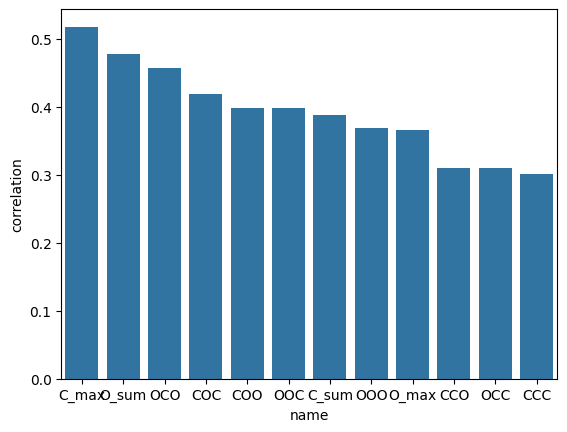

In [ ]:
sns.barplot(df2, x="name", y="correlation")

**Conclusion**  
We can see that the Create and Open features are the most relevant, since in a ransomeware attack, the number of file creation and file opening operations is highly relevant for detecting ransomeware behavior.

## III / Optimization to find the best learning models

We used AutoWeka to find the best learning models for our dataset, and here is the results.


------- 5 BEST CONFIGURATIONS -------

These are the 5 best configurations, as ranked by SMAC
Please note that this list only contains configurations evaluated on at least 10 folds,
If you need more configurations, please consider running Auto-WEKA for a longer time.

**1. Configuration #1:**
- SMAC Score: 0.06504921931889844
- Argument String:
  - -_0__wekaclassifierslazykstar_00_INT_B 42 -_0__wekaclassifierslazykstar_01_E REMOVE_PREV -_0__wekaclassifierslazykstar_02_M m -aseval__wekaattributeselectioncfssubseteval_00_0_M REMOVE_PREV -aseval__wekaattributeselectioncfssubseteval_01_1_L REMOVE_PREV -assearch__wekaattributeselectiongreedystepwise_00_0_C REMOVED -assearch__wekaattributeselectiongreedystepwise_01_1_B REMOVED -assearch__wekaattributeselectiongreedystepwise_02_2_R REMOVE_PREV -assearch__wekaattributeselectiongreedystepwise_03_4_INT_N 998 -attributeeval weka.attributeSelection.CfsSubsetEval -attributesearch weka.attributeSelection.GreedyStepwise -attributetime 60.0 -targetclass weka.classifiers.lazy.KStar

**2. Configuration #2:**
- SMAC Score: 0.06631590243207829
- Argument String:
  - -_0__wekaclassifierstreesrandomforest_00_INT_I 26 -_0__wekaclassifierstreesrandomforest_01_features_HIDDEN 1 -_0__wekaclassifierstreesrandomforest_03_2_INT_K 10 -_0__wekaclassifierstreesrandomforest_04_depth_HIDDEN 0 -_0__wekaclassifierstreesrandomforest_05_1_INT_depth 0 -attributesearch NONE -attributetime 60.0 -targetclass weka.classifiers.trees.RandomForest

**3. Configuration #3:**
- SMAC Score: 0.06775920624256347
- Argument String:
  - -_0__wekaclassifierstreesrandomforest_00_INT_I 10 -_0__wekaclassifierstreesrandomforest_01_features_HIDDEN 0 -_0__wekaclassifierstreesrandomforest_02_1_INT_K 0 -_0__wekaclassifierstreesrandomforest_04_depth_HIDDEN 0 -_0__wekaclassifierstreesrandomforest_05_1_INT_depth 0 -attributesearch NONE -attributetime 60.0 -targetclass weka.classifiers.trees.RandomForest

**4. Configuration #4:**
- SMAC Score: 0.07631141611211838
- Argument String:
  - -_0__wekaclassifiersfunctionsmultilayerperceptron_00_L 0.2514213267001907 -_0__wekaclassifiersfunctionsmultilayerperceptron_01_M 0.6612956854811879 -_0__wekaclassifiersfunctionsmultilayerperceptron_02_B REMOVED -_0__wekaclassifiersfunctionsmultilayerperceptron_03_H o -_0__wekaclassifiersfunctionsmultilayerperceptron_04_C REMOVE_PREV -_0__wekaclassifiersfunctionsmultilayerperceptron_05_R REMOVE_PREV -_0__wekaclassifiersfunctionsmultilayerperceptron_06_D REMOVE_PREV -_0__wekaclassifiersfunctionsmultilayerperceptron_07_S 1 -aseval__wekaattributeselectioncfssubseteval_00_0_M REMOVED -aseval__wekaattributeselectioncfssubseteval_01_1_L REMOVE_PREV -assearch__wekaattributeselectiongreedystepwise_00_0_C REMOVED -assearch__wekaattributeselectiongreedystepwise_01_1_B REMOVE_PREV -assearch__wekaattributeselectiongreedystepwise_02_2_R REMOVED -attributeeval weka.attributeSelection.CfsSubsetEval -attributesearch weka.attributeSelection.GreedyStepwise -attributetime 60.0 -targetclass weka.classifiers.functions.MultilayerPerceptron

**5. Configuration #5:**
- SMAC Score: 0.08590975461177834
- Argument String:
  - -_0__wekaclassifierstreesm5p_00_N REMOVED -_0__wekaclassifierstreesm5p_01_INT_M 43 -_0__wekaclassifierstreesm5p_02_U REMOVE_PREV -_0__wekaclassifierstreesm5p_03_R REMOVED -aseval__wekaattributeselectioncfssubseteval_00_0_M REMOVED -aseval__wekaattributeselectioncfssubseteval_01_1_L REMOVE_PREV -assearch__wekaattributeselectionbestfirst_00_0_D 1 -assearch__wekaattributeselectionbestfirst_01_1_INT_N 9 -attributeeval weka.attributeSelection.CfsSubsetEval -attributesearch weka.attributeSelection.BestFirst -attributetime 60.0 -targetclass weka.classifiers.trees.M5P


**Conclusion**  
In 5 configurations, we can see that the tree remain the best models for the dataset.

## IV / Solve the unbalanced data problem

In [ ]:
training['Labels'].value_counts()

Labels
0    1434
1      14
Name: count, dtype: int64

In [ ]:
testing['Labels'].value_counts()

Labels
0    1317
1      21
Name: count, dtype: int64

### 1. Undersampling

Here we've created an Undersampling algorithm, the objective being that if 2 lines are 99% similar, they should be merged. The comparison is only made on the attributes with the greatest impact.

*   calculate_row_difference(row1,row2,options):
*   average_rows(row1, row2, nbr_columns):
*   merge_rows_and_save(df_t, threshold,options_t,minimum_options):


In [ ]:
import pandas as pd
def calculate_row_difference(row1, row2,options):
    # Calculate the rate of difference for each column, ensuring values are treated as integers

    differences = []

    for col in options:
        num = max((int(row1[col]) + int(row2[col])) / 2 ,1)
        den = max(int(row1[col]), int(row2[col]),1)
        differences.append(abs(num / den))

    # Calculate the average difference across all columns
    return sum(differences) / len(differences)

def average_rows(row1, row2, nbr_columns):

    # Return the average of two rows, rounding to the nearest integer
    return [round((int(row1[col]) + int(row2[col])) / 2) for col in range(nbr_columns)]

def merge_rows_and_save(df_t, threshold,options_t,minimum_options):

    options = options_t.copy()

    df_merged = []

    real_number_option = len(options) - minimum_options

    for h in range(real_number_option):
        df = df_t.copy()

        rows_to_delete = set()
        new_rows = []
        start = 1
        nbr_columns = len(df.columns)

        if rows_to_delete:
            print("hey")
        #iterate until no rows are deleted
        while rows_to_delete or start == 1:

            start = 0
            rows_to_delete = set()
            new_rows = []
            for i in range(len(df)):
                for j in range(i + 1, len(df)):
                    if i not in rows_to_delete and j not in rows_to_delete:
                        # Calculate the average rate of difference

                        row11 = df.iloc[i]
                        row22 = df.iloc[j]
                        #transforme the rows to list
                        row1 = df.iloc[i].tolist()


                        difference_rate = calculate_row_difference(row11,row22,options)
                        #print( "differnce rate",difference_rate)

                        # If the difference rate is above the threshold, mark both for deletion and add their average

                        if difference_rate > threshold:
                            rows_to_delete.add(i)
                            rows_to_delete.add(j)
                            averaged_row = average_rows(df.iloc[i], df.iloc[j], nbr_columns)
                            # Handle Labels column if necessary, for now we just take the first label
                            new_rows.append(averaged_row)


                if i not in rows_to_delete:
                    new_rows.append(row1)

            #put new rows in the dataframe
            df = pd.DataFrame(new_rows, columns=df.columns)
            print(len(df))


        # save the new rows to a new csv file
        df_merged = pd.DataFrame(new_rows, columns=df.columns)
        df_merged.to_csv("merged_data_"+ str(threshold) +"_"+''.join(options) +"_" +".csv", index=False)

        options.pop(-1)


    return df_merged

# Example usagein csv and semi-colon separated
df = pd.read_csv('testing.csv', sep=';')

values = [0.99]
options = ["C_max","O_sum","OCO","COC","COO","OOC","C_sum","OOO","O_max","CCO","OCC","CCC"]
minimum_options = 11




for i in values:
    df_merged = merge_rows_and_save(df,i,options,minimum_options)
    print(options)



785
518
400
344
320
309
308
306
306
['C_max', 'O_sum', 'OCO', 'COC', 'COO', 'OOC', 'C_sum', 'OOO', 'O_max', 'CCO', 'OCC', 'CCC']


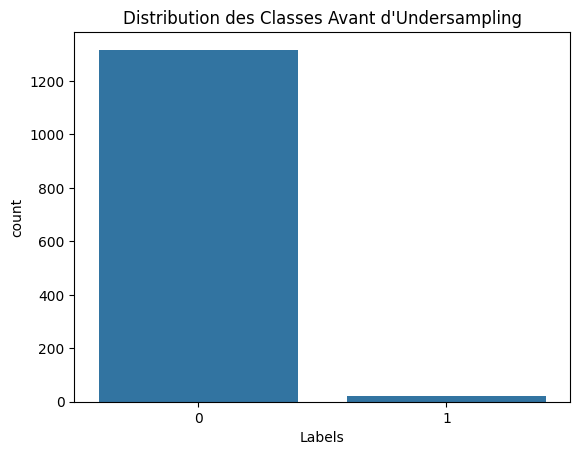

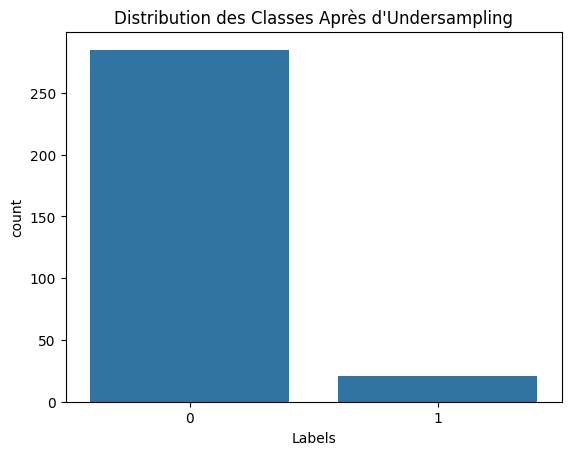

In [ ]:
sns.countplot(x='Labels', data=df)
plt.title("Distribution des Classes Avant d'Undersampling")
plt.show()

# Supposons que df_resampled est votre DataFrame après l'oversampling
sns.countplot(x='Labels', data=df_merged)
plt.title("Distribution des Classes Après d'Undersampling")
plt.show()

### 2. Oversampling

After trying to reduce the data, we noticed that the gap was still far too wide, so we applied probabilistic Oversampling to balance the dataset. To do this, we used the SMOTE method

In [ ]:
from imblearn.over_sampling import SMOTE
def export_arff(name, dataset):
  arff.dump(name + '.arff'
        , dataset.values
        , relation=name
        , names=dataset.columns)

In [ ]:
df_merged_data = pd.read_csv('/content/merged_data_0_99.csv', sep=',')  # Assurez-vous que le séparateur correspond à celui de votre fichier CSV
X = df_merged_data.drop('Labels', axis=1)
y = df_merged_data['Labels']

# Initialize SMOTE
sm = SMOTE(random_state=42)

# Apply SMOTE to the minority class
X_resampled_smote, y_resampled_smote = sm.fit_resample(X, y)

# The returned data from SMOTE will be the original data plus the synthetic samples for the minority class
# You can now create a DataFrame with the resampled data
df_resampled = pd.DataFrame(X_resampled_smote, columns=X.columns)
df_resampled['Labels'] = y_resampled_smote

# Let's check the balance of the classes after the resampling
print(df_resampled['Labels'].value_counts())


Labels
0    285
1    285
Name: count, dtype: int64


### Analysing tree graphics

After using Weka, we get different tree that marks how it classify the data.

#### A) With the original unbalanced data

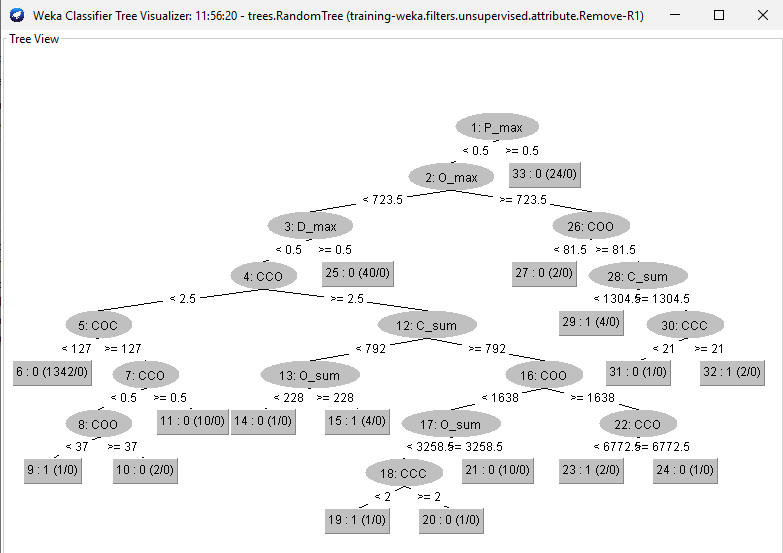

**Analysis**  
- Non Malware (0) : 1434  
- Malware (1) : 14  

We have 11 leafs that classify the process to 0 and 6 to 1.  
That's a percentage of 33% of classifying 1 for a process.

#### B) With the undersampling data




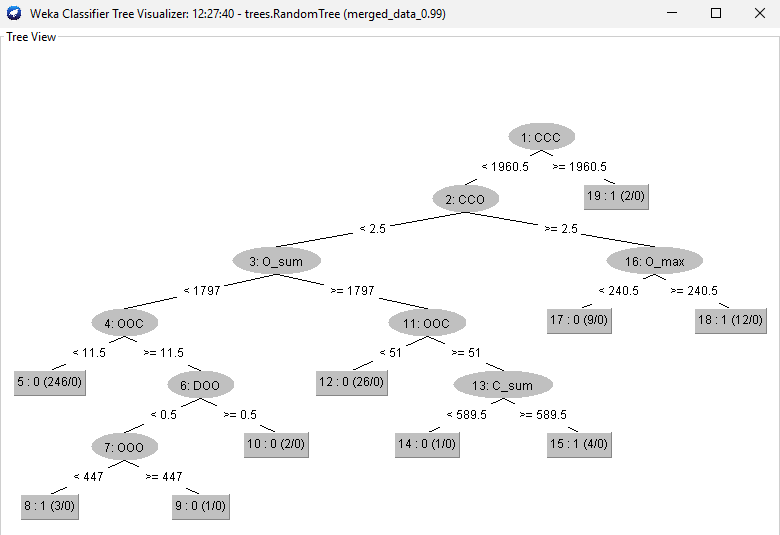

**Analysis**  
- Non Malware (0) : 285  
- Malware (1) : 21  


We have 6 leafs that classify the process to 0 and 4 to 1.  
That's a percentage of 40% of classifying 1 for a process.

#### C) With the oversampling data


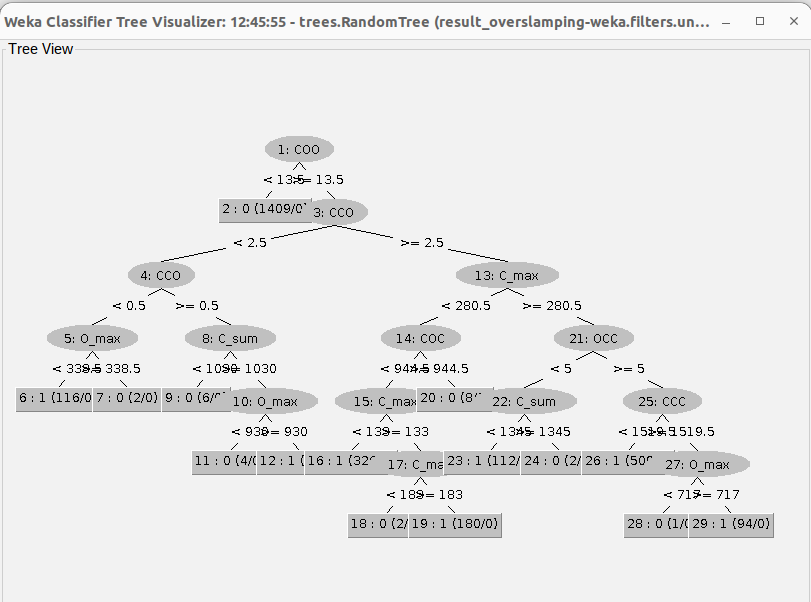

**Analysis**  
- Non Malware (0) : 1434  
- Malware (1) : 1434  

We have 8 leafs that classify the process to 0 and 7 to 1.  
That's a percentage of 46% of classifying 1 for a process.